# CPIS by Country

This notebook processes Corporate Private Irrigation Scheme (CPIS) data for Africa. It:
1. Loads CPIS data from 2000 and 2021
2. Overlays CPIS data with African country boundaries
3. Calculates areas and adds year information
4. Filters to Sub-Saharan African countries
5. Creates visualization maps comparing 2000 and 2021 data

In [4]:
import matplotlib.pyplot as plt
import geopandas as gpd
from utility import load_config, resolve_path, ssa_iso
from spatial_utility import load_and_reproject

## Load Input Data

In [5]:
# Load African boundaries and CPIS data
try:
    config = load_config()
    
    # Load and reproject Africa boundaries
    Africa_boundaries = load_and_reproject(
        resolve_path(config['Africa_boundaries_shp_path']), 
        target_crs="EPSG:4326"  # Keep original CRS for overlay
    )
    
    # Load and reproject CPIS data for 2000 and 2021
    cPIS2000 = load_and_reproject(
        resolve_path(config['CPIS_2000_shp_path']), 
        target_crs="EPSG:4326"  # Keep original CRS for overlay
    )
    cPIS2021 = load_and_reproject(
        resolve_path(config['CPIS_2021_shp_path']), 
        target_crs="EPSG:4326"  # Keep original CRS for overlay
    )
    
    print(f"Loaded Africa boundaries with {len(Africa_boundaries)} countries")
    print(f"Loaded CPIS 2000 with {len(cPIS2000)} features")
    print(f"Loaded CPIS 2021 with {len(cPIS2021)} features")
except Exception as e:
    print(f"Error loading input data: {e}")

Loaded Africa boundaries with 57 countries
Loaded CPIS 2000 with 117298 features
Loaded CPIS 2021 with 234382 features


## Visualize Input Data

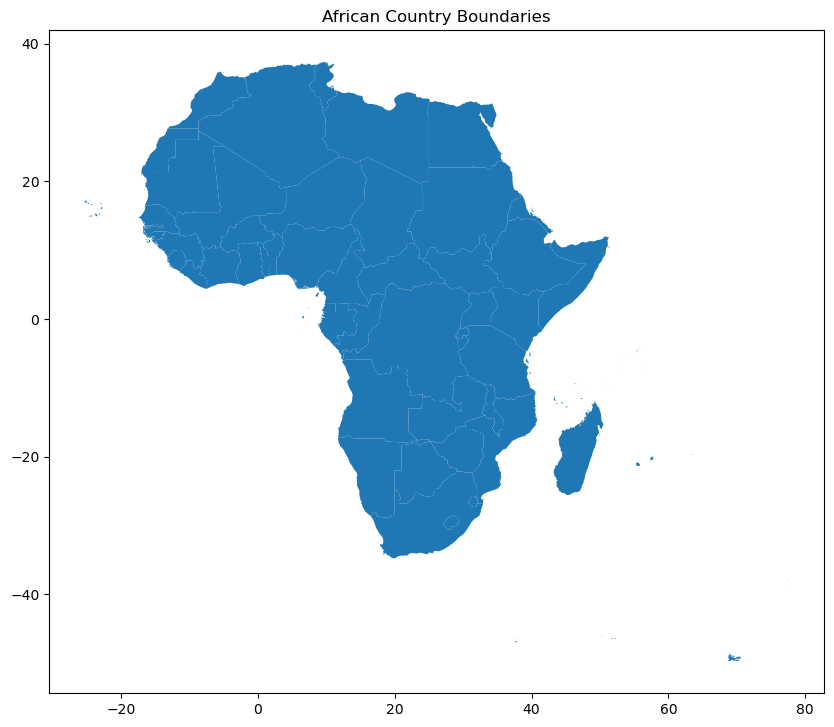

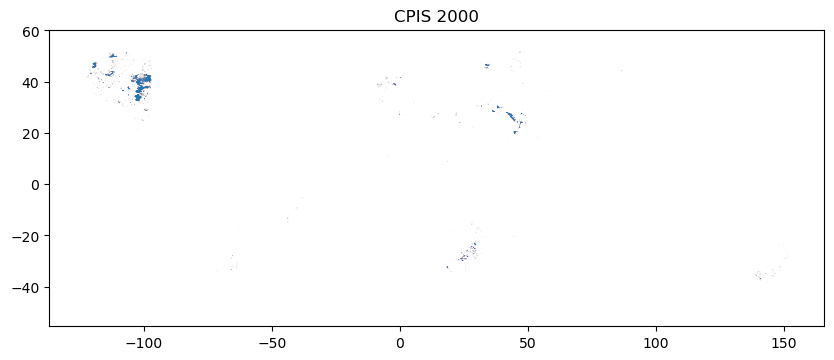

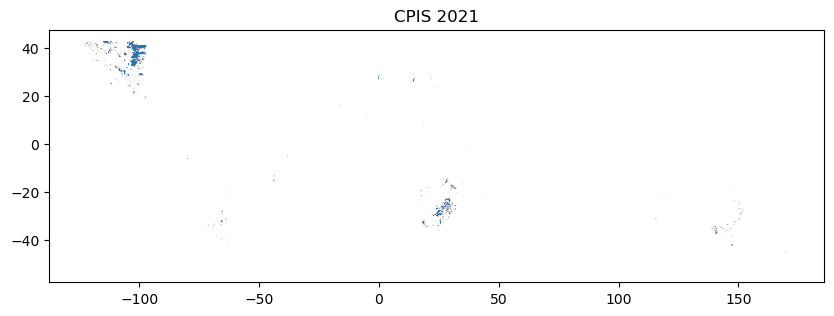

In [6]:
# Plot Africa boundaries
fig, ax = plt.subplots(figsize=(10, 10))
Africa_boundaries.plot(ax=ax)
ax.set_title('African Country Boundaries')
plt.show()

# Plot CPIS 2000
fig, ax = plt.subplots(figsize=(10, 10))
cPIS2000.plot(ax=ax)
ax.set_title('CPIS 2000')
plt.show()

# Plot CPIS 2021
fig, ax = plt.subplots(figsize=(10, 10))
cPIS2021.plot(ax=ax)
ax.set_title('CPIS 2021')
plt.show()

## Overlay CPIS Data with African Boundaries

In [7]:
try:
    # Overlay CPIS data with Africa boundaries
    CPIS2000_Africa = gpd.overlay(cPIS2000, Africa_boundaries, how='intersection')
    CPIS2021_Africa = gpd.overlay(cPIS2021, Africa_boundaries, how='intersection')
    
    # Add year column for clarity
    CPIS2000_Africa['Year'] = 2000
    CPIS2021_Africa['Year'] = 2021
    
    # Reproject to Web Mercator for area calculation
    CPIS2000_Africa = CPIS2000_Africa.to_crs(epsg=3857)
    CPIS2021_Africa = CPIS2021_Africa.to_crs(epsg=3857)
    
    # Add area column
    CPIS2000_Africa['Area_m2'] = CPIS2000_Africa.geometry.area
    CPIS2021_Africa['Area_m2'] = CPIS2021_Africa.geometry.area
    
    print(f"CPIS 2000 in Africa: {len(CPIS2000_Africa)} features")
    print(f"CPIS 2021 in Africa: {len(CPIS2021_Africa)} features")
except Exception as e:
    print(f"Error overlaying data: {e}")

CPIS 2000 in Africa: 8581 features
CPIS 2021 in Africa: 29146 features


## Save Results and Filter to Sub-Saharan Africa

In [8]:
try:
    # Save all Africa results
    CPIS2000_Africa.to_file(resolve_path(config['Africa_CPIS_2000_shp_path']))
    CPIS2021_Africa.to_file(resolve_path(config['Africa_CPIS_2021_shp_path']))
    print("Saved Africa CPIS data for 2000 and 2021")
    
    # Ensure the 'ISO' column exists before filtering
    if 'ISO' not in CPIS2000_Africa.columns or 'ISO' not in CPIS2021_Africa.columns:
        raise KeyError("The 'ISO' column is missing in the CPIS data. Ensure it is added during processing.")
    
    # Filter to Sub-Saharan Africa using the ssa_iso list
    CPIS2000_SSA = CPIS2000_Africa[CPIS2000_Africa['ISO'].isin(ssa_iso)].copy()
    CPIS2021_SSA = CPIS2021_Africa[CPIS2021_Africa['ISO'].isin(ssa_iso)].copy()
    
    # Save SSA results
    CPIS2000_SSA.to_file(resolve_path(config['SSA_CPIS_2000_shp_path']))
    CPIS2021_SSA.to_file(resolve_path(config['SSA_CPIS_2021_shp_path']))
    print("Saved SSA CPIS data for 2000 and 2021")
    
    print(f"CPIS 2000 in SSA: {len(CPIS2000_SSA)} features")
    print(f"CPIS 2021 in SSA: {len(CPIS2021_SSA)} features")
except KeyError as ke:
    print(f"KeyError: {ke}")
except Exception as e:
    print(f"Error saving results: {e}")

Saved Africa CPIS data for 2000 and 2021
Saved SSA CPIS data for 2000 and 2021
CPIS 2000 in SSA: 7309 features
CPIS 2021 in SSA: 27439 features


## Visualize Results

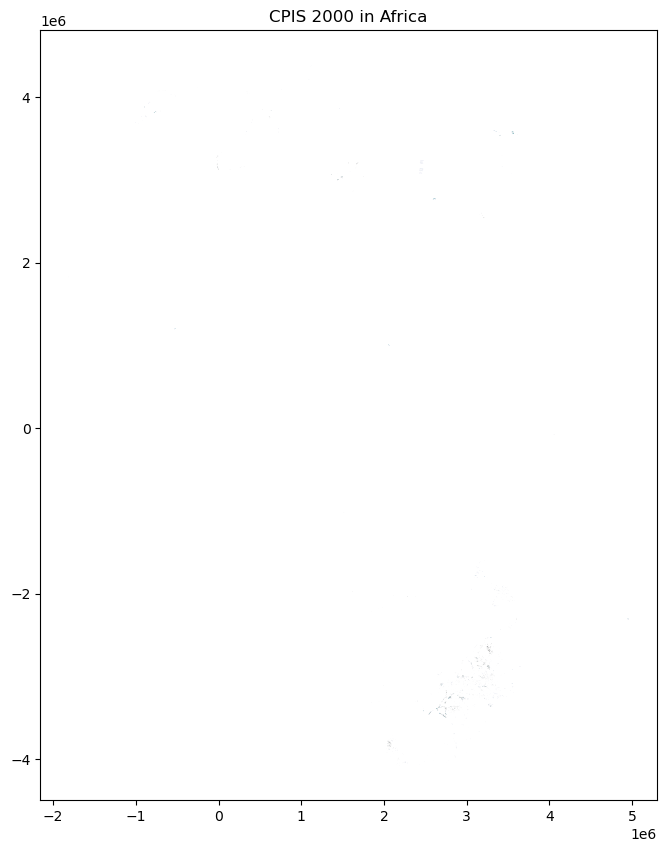

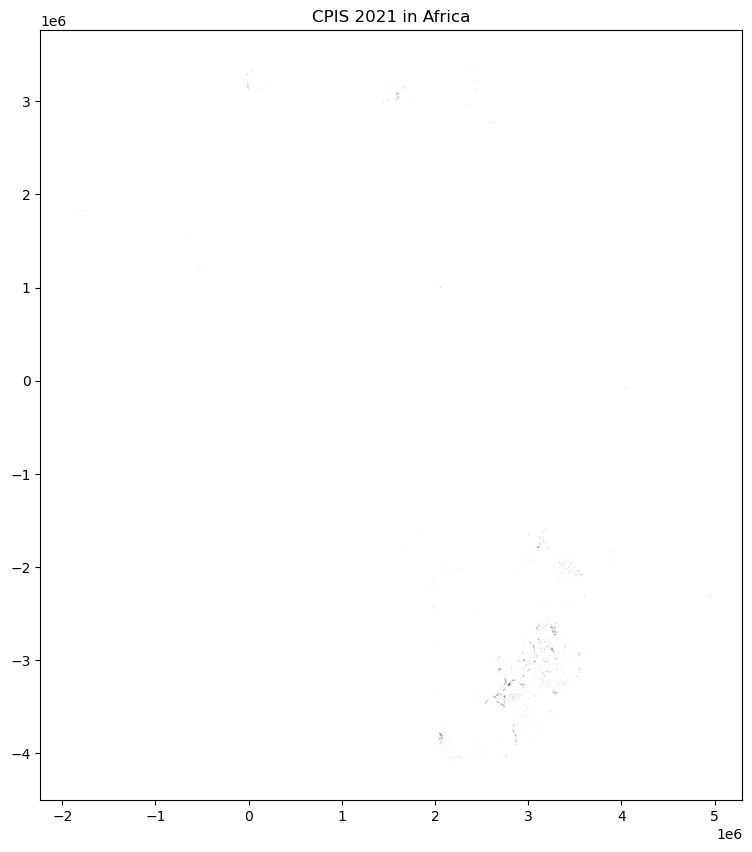

In [6]:
# Plot CPIS 2000 in Africa
fig, ax = plt.subplots(figsize=(10, 10))
CPIS2000_Africa.plot(ax=ax)
ax.set_title('CPIS 2000 in Africa')
plt.show()

# Plot CPIS 2021 in Africa
fig, ax = plt.subplots(figsize=(10, 10))
CPIS2021_Africa.plot(ax=ax)
ax.set_title('CPIS 2021 in Africa')
plt.show()

## Create Comparison Map

CPIS_Africa CRS: EPSG:3857
CPIS2000_Africa CRS: EPSG:3857
CPIS2021_Africa CRS: EPSG:3857
Africa_boundaries_reproj CRS: EPSG:3857


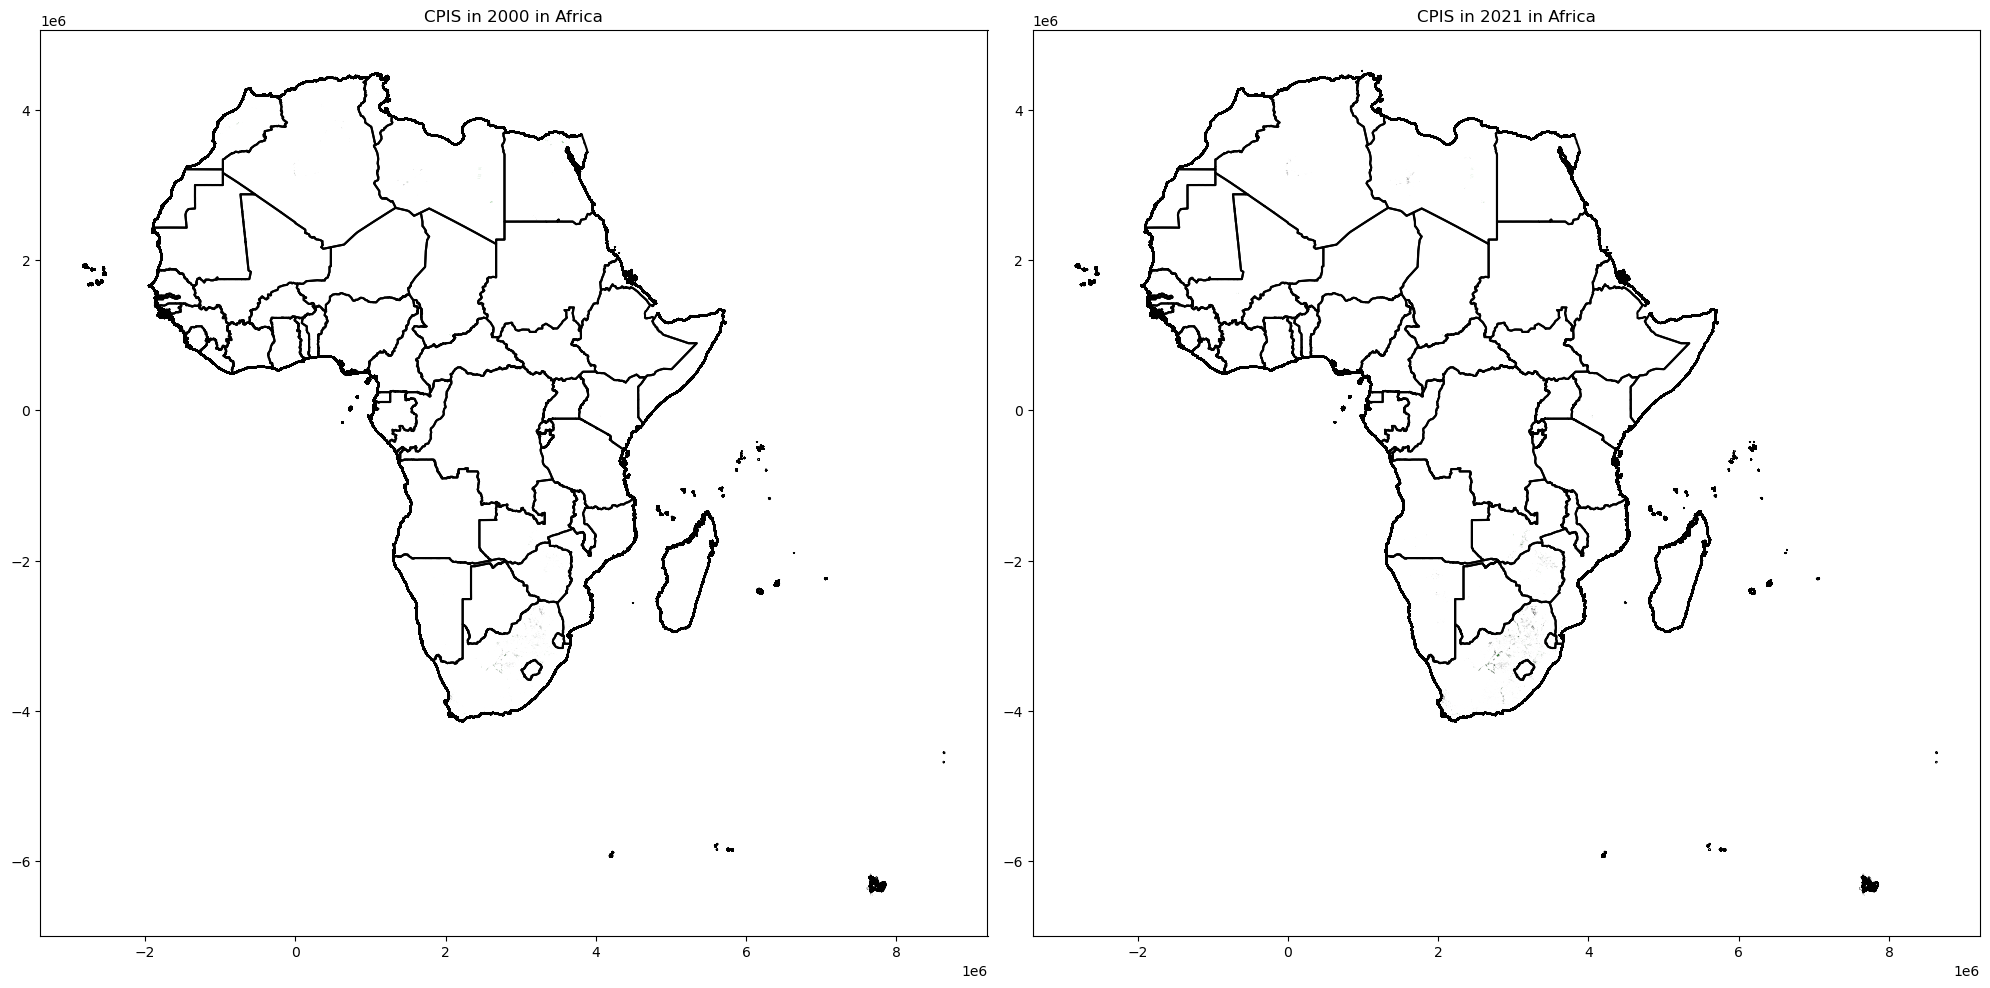

Saved comparison figure to Data/Output/Process/1_Figure0.png


In [7]:
try:
    # Load the combined CPIS data (if available)
    CPIS_Africa = utility.load_and_reproject(config['Africa_CPIS_shp_path'], target_crs="EPSG:3857")
    
    # If not available, create it by combining 2000 and 2021 data
    if CPIS_Africa is None:
        print("Combined CPIS data not found, creating from 2000 and 2021 data")
        CPIS_Africa = pd.concat([CPIS2000_Africa, CPIS2021_Africa])
    
    # Ensure Africa boundaries are in the same CRS
    Africa_boundaries_reproj = Africa_boundaries.to_crs(epsg=3857)
    
    # Print CRS information for debugging
    print(f"CPIS_Africa CRS: {CPIS_Africa.crs}")
    print(f"CPIS2000_Africa CRS: {CPIS2000_Africa.crs}")
    print(f"CPIS2021_Africa CRS: {CPIS2021_Africa.crs}")
    print(f"Africa_boundaries_reproj CRS: {Africa_boundaries_reproj.crs}")
    
    # Buffer the geometry to make it more visible
    CPIS_Africa['geometry'] = CPIS_Africa.geometry.buffer(0.5)
    
    # Create a single plot with two facets
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    
    # Plot the CPIS data for 2000
    Africa_boundaries_reproj.boundary.plot(ax=axes[0], color='black')
    CPIS_Africa[CPIS_Africa['Year'] == 2000].plot(ax=axes[0], color='green')
    axes[0].set_title('CPIS in 2000 in Africa')
    
    # Plot the CPIS data for 2021
    Africa_boundaries_reproj.boundary.plot(ax=axes[1], color='black')
    CPIS_Africa[CPIS_Africa['Year'] == 2021].plot(ax=axes[1], color='green')
    axes[1].set_title('CPIS in 2021 in Africa')
    
    # Adjust layout and save the plot
    plt.tight_layout()
    plt.savefig(utility.resolve_path(config['1_Figure0']))
    plt.show()
    print(f"Saved comparison figure to {config['1_Figure0']}")
except Exception as e:
    print(f"Error creating comparison map: {e}")